# TO DOWNLOAD

In [46]:
!pip install ipymarkup
!pip install yargy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [47]:
import pandas as pd
import numpy as np

import json

from ipymarkup import show_span_ascii_markup as show_markup

from yargy import (
    Parser,
    rule, or_, and_, not_
)
from yargy.predicates import (
    eq, in_,
    type, normalized,
    dictionary,
    gte, lte
)
from yargy.pipelines import (
    pipeline,
    morph_pipeline
)
from yargy.interpretation import (
    fact,
    attribute
)
from yargy.tokenizer import MorphTokenizer, EOL

from random import seed, sample

seed(41)

# Препроцессинг датасета

In [48]:
df_resume = pd.read_csv('/content/df_resume.csv')

In [49]:
df_resume = df_resume[~df_resume.labels.isna()]

# Yargy parser

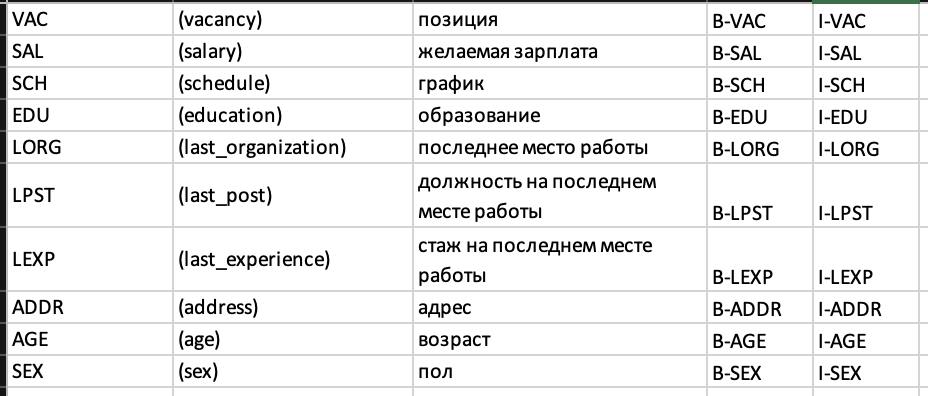

In [50]:
df_resume.resume[3]

'id резюме : 32029550 обновлено 24-04-2023 16:05:59 44 года , мужчина Санкт-Петербург , Автово Гражданство : Россия Желаемая должность и зарплата Прораб дорожное строительство ( благоустройство ) 100 000 руб . График , место работы Полный рабочий день . Ищу работу в городе : Санкт-Петербург . Командировки возможны . Стаж в желаемой должности 5 лет Специализации Архитектура , проектирование , Сметное дело , Снабжение , закупки , тендеры , Геодезия , землеустройство , Инженерные системы , Автодорожное строительство Профессиональные навыки Ведение переговоров , управление персоналом , чтение чертежей , работа с проектно-сметной документацией , строительно-монтажные работы , руководство бригадой , контроль качества выполненных работ , ведение объекта Основное образование Высшее , Ивановский государственный университет , 2019 ОПЫТ РАБОТЫ 2008 , сентябрь — 2018 , сентябрь , 10 лет директор ооо дорпромстрой административно хозяйственная деятельность . 2001 , июнь — 2008 , сентябрь , 7 лет мас

## Utils

In [51]:
def load_lines(path):
    with open(path) as file:
        for line in file:
            yield line.rstrip('\n')

def show_matches(rule, *lines):
    parser = Parser(rule)
    for line in lines:
        matches = parser.findall(line)
        spans = [_.span for _ in matches]
        show_markup(line, spans)

## Rules

In [52]:
from yargy.tokenizer import MorphTokenizer, EOL
TOKENIZER = MorphTokenizer().remove_types(EOL)

In [53]:
INT = type('INT')
COMMA = eq(',')
COLON = eq(':')

### SEX

In [54]:
Intro_gender = fact('Intro', ['gender'])

GENDERS = {
    'женщина': 'female',
    'мужчина': 'male'
}

GENDER = in_(GENDERS).interpretation(
    Intro_gender.gender.custom(GENDERS.get)
)

INTRO_GENDER = rule(GENDER)

show_matches(
    INTRO_GENDER,
    df_resume.resume[3]
)

id резюме : 32029550 обновлено 24-04-2023 16:05:59 44 года , мужчина 
                                                             ─────── 
Санкт-Петербург , Автово Гражданство : Россия Желаемая должность и 
зарплата Прораб дорожное строительство ( благоустройство ) 100 000 руб
 . График , место работы Полный рабочий день . Ищу работу в городе : 
Санкт-Петербург . Командировки возможны . Стаж в желаемой должности 5 
лет Специализации Архитектура , проектирование , Сметное дело , 
Снабжение , закупки , тендеры , Геодезия , землеустройство , 
Инженерные системы , Автодорожное строительство Профессиональные 
навыки Ведение переговоров , управление персоналом , чтение чертежей ,
 работа с проектно-сметной документацией , строительно-монтажные 
работы , руководство бригадой , контроль качества выполненных работ , 
ведение объекта Основное образование Высшее , Ивановский 
государственный университет , 2019 ОПЫТ РАБОТЫ 2008 , сентябрь — 2018 
, сентябрь , 10 лет директор ооо дорпромстрой адми

In [55]:
def get_labels_from_yargy(text, spans, label):
    if spans[-1] != len(text)-1:
        spans.append(len(text)-1)
    labels_from_yargy = []
    tags_out = True
    for i in range(len(spans)-1):
        if text[spans[i]] != ' ' and tags_out and i!=0:
            try:
                spans[i] += text[spans[i]:spans[i+1]].index(" ")
            except:
                pass
        for word in text[spans[i]:spans[i+1]].split():
            if tags_out:
                labels_from_yargy.append('O')
            else:
                labels_from_yargy.append(label)
        tags_out = not tags_out
    return labels_from_yargy

In [56]:
parser = Parser(INTRO_GENDER, tokenizer=TOKENIZER)

labeled_sex_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    if matches:
        match = matches[0]
        start, end = match.span
        labeled_sex_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, [0, start, end], 'SEX'))]

In [57]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_sex_token_from_yargy, 
                                             orient='index', 
                                             columns=['sex_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)

df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df_resume.merge(df_label_from_yargy, on='id', how='left')

## AGE

In [58]:
Age = fact(
    'Age',
    ['age']
)

AGE_INT = and_(
    gte(14),
    lte(75)
).interpretation(
    Age.age.custom(int)
)

AGE = rule(
    AGE_INT,
    normalized('год')
)

show_matches(
    AGE,
    df_resume.resume[3]
)

id резюме : 32029550 обновлено 24-04-2023 16:05:59 44 года , мужчина 
                                                   ───────           
Санкт-Петербург , Автово Гражданство : Россия Желаемая должность и 
зарплата Прораб дорожное строительство ( благоустройство ) 100 000 руб
 . График , место работы Полный рабочий день . Ищу работу в городе : 
Санкт-Петербург . Командировки возможны . Стаж в желаемой должности 5 
лет Специализации Архитектура , проектирование , Сметное дело , 
Снабжение , закупки , тендеры , Геодезия , землеустройство , 
Инженерные системы , Автодорожное строительство Профессиональные 
навыки Ведение переговоров , управление персоналом , чтение чертежей ,
 работа с проектно-сметной документацией , строительно-монтажные 
работы , руководство бригадой , контроль качества выполненных работ , 
ведение объекта Основное образование Высшее , Ивановский 
государственный университет , 2019 ОПЫТ РАБОТЫ 2008 , сентябрь — 2018 
, сентябрь , 10 лет директор ооо дорпромстрой адми

In [59]:
parser = Parser(AGE)

labeled_age_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    if matches:
        match = matches[0]
        start, end = match.span
        labeled_age_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, [0, start, end], 'AGE'))]

In [60]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_age_token_from_yargy, 
                                             orient='index', 
                                             columns=['age_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

## SAL

In [61]:
Money = fact(
    'Money',
    ['amount', 'currency']
)

CURRENCIES = {
    'рублей': 'RUB',
    'руб': 'RUB',
    'грн': 'GRN',
    'бел рублей': 'BEL',
    'бел руб': 'BEL',
    'RUB': 'RUB',
    'EUR': 'EUR',
    'KZT': 'KZT',
    'USD': 'USD',
    'KGS': 'KGS'
}

CURRENCY = pipeline(CURRENCIES).interpretation(
    Money.currency.normalized().custom(CURRENCIES.get)
)


def normalize_amount(value):
    return int(value.replace(' ', ''))


AMOUNT = or_(
    rule(INT),
    rule(INT, INT),
    rule(INT, "-", INT),
)

MONEY = rule(
    AMOUNT,
    CURRENCY
)

show_matches(
    MONEY,
    df_resume.resume[3]
)

id резюме : 32029550 обновлено 24-04-2023 16:05:59 44 года , мужчина 
Санкт-Петербург , Автово Гражданство : Россия Желаемая должность и 
зарплата Прораб дорожное строительство ( благоустройство ) 100 000 руб
                                                           ───────────
 . График , место работы Полный рабочий день . Ищу работу в городе : 
Санкт-Петербург . Командировки возможны . Стаж в желаемой должности 5 
лет Специализации Архитектура , проектирование , Сметное дело , 
Снабжение , закупки , тендеры , Геодезия , землеустройство , 
Инженерные системы , Автодорожное строительство Профессиональные 
навыки Ведение переговоров , управление персоналом , чтение чертежей ,
 работа с проектно-сметной документацией , строительно-монтажные 
работы , руководство бригадой , контроль качества выполненных работ , 
ведение объекта Основное образование Высшее , Ивановский 
государственный университет , 2019 ОПЫТ РАБОТЫ 2008 , сентябрь — 2018 
, сентябрь , 10 лет директор ооо дорпромстрой адм

In [62]:
parser = Parser(MONEY)

labeled_sal_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    if matches:
        match = matches[0]
        start, end = match.span
        labeled_sal_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, [0, start, end], 'SAL'))]

In [63]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_sal_token_from_yargy, 
                                             orient='index', 
                                             columns=['sal_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

## ADDR

In [64]:
AREAS = set(load_lines('areas.txt'))

Address = fact(
    'Location',
    ['area', 'metro']
)

AREA = morph_pipeline(AREAS).interpretation(
    Address.area
)

ADDR = or_(
    rule(
      AREA
    ),
).interpretation(
    Address
)

show_matches(
    ADDR,
    df.resume[3]
)

id резюме : 22177797 обновлено 24-04-2023 21:50:57 58 лет , мужчина 
Москва Гражданство : Россия Желаемая должность и зарплата Охранник-
──────               ──────                                        
администратор 50 000 руб . График , место работы Полный рабочий день .
 Ищу работу в городе : Москва . Командировки невозможны . Стаж в 
                       ──────                                    
желаемой должности Нет опыта Профессиональные навыки Охрана объектов ,
 видеонаблюдение , предотвращение хищений , охрана имущества , 
обеспечение контрольно-пропускного режима , обеспечение пропускного 
режима Основное образование Среднее Подробнее о себе Семейное 
положение Холост , Детей нет 


In [65]:
parser = Parser(ADDR)

labeled_addr_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    spans = [0]
    if matches:
        for i in range(len(matches)):
            match_i = matches[i]
            spans.extend(match_i.span)
        labeled_addr_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, spans, 'ADDR'))]

In [66]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_addr_token_from_yargy, 
                                             orient='index', 
                                             columns=['addr_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

### VAC

In [67]:
SPECIALIZATIONS = set(load_lines('specialization.txt'))
SUBSPECIALIZATIONS = set(load_lines('subspecialization.txt'))


SPECIALIZATION = pipeline(SPECIALIZATIONS)
SUBSPECIALIZATION = pipeline(SUBSPECIALIZATIONS)

POSITION = rule(
    or_(
        SPECIALIZATION,
        SUBSPECIALIZATION
    )
)

show_matches(
    POSITION,
    df.resume[3]
)

id резюме : 22177797 обновлено 24-04-2023 21:50:57 58 лет , мужчина 
Москва Гражданство : Россия Желаемая должность и зарплата Охранник-
                                                          ──────── 
администратор 50 000 руб . График , место работы Полный рабочий день .
 Ищу работу в городе : Москва . Командировки невозможны . Стаж в 
желаемой должности Нет опыта Профессиональные навыки Охрана объектов ,
 видеонаблюдение , предотвращение хищений , охрана имущества , 
обеспечение контрольно-пропускного режима , обеспечение пропускного 
режима Основное образование Среднее Подробнее о себе Семейное 
положение Холост , Детей нет 


In [68]:
parser = Parser(POSITION, tokenizer=TOKENIZER)

labeled_vac_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    spans = [0]
    if matches:
        for i in range(len(matches)):
            match_i = matches[i]
            spans.extend(match_i.span)
        labeled_vac_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, spans, 'VAC'))]

In [69]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_vac_token_from_yargy, 
                                             orient='index', 
                                             columns=['vac_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

### SCH

In [70]:
Intro_sch = fact('Intro', ['schedule'])

TYPES = {
    'полный день': 'full',
    'полный рабочий день': 'full',
    'сменный график': 'shift_schedule',
    'свободный график': 'free_schedule',
    'частичная занятость': 'part_time',
    'гибкий график': 'flex'
}

TYPE = morph_pipeline(TYPES).interpretation(
    Intro_sch.schedule.custom(TYPES.get)
)

TYPES_RULE = rule(TYPE)

show_matches(
    TYPES_RULE,
    df_resume.resume[3]
)

id резюме : 32029550 обновлено 24-04-2023 16:05:59 44 года , мужчина 
Санкт-Петербург , Автово Гражданство : Россия Желаемая должность и 
зарплата Прораб дорожное строительство ( благоустройство ) 100 000 руб
 . График , место работы Полный рабочий день . Ищу работу в городе : 
                         ───────────────────                         
Санкт-Петербург . Командировки возможны . Стаж в желаемой должности 5 
лет Специализации Архитектура , проектирование , Сметное дело , 
Снабжение , закупки , тендеры , Геодезия , землеустройство , 
Инженерные системы , Автодорожное строительство Профессиональные 
навыки Ведение переговоров , управление персоналом , чтение чертежей ,
 работа с проектно-сметной документацией , строительно-монтажные 
работы , руководство бригадой , контроль качества выполненных работ , 
ведение объекта Основное образование Высшее , Ивановский 
государственный университет , 2019 ОПЫТ РАБОТЫ 2008 , сентябрь — 2018 
, сентябрь , 10 лет директор ооо дорпромстрой адми

In [71]:
parser = Parser(TYPES_RULE, tokenizer=TOKENIZER)

labeled_sch_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    spans = [0]
    if matches:
        for i in range(len(matches)):
            match_i = matches[i]
            spans.extend(match_i.span)
        labeled_sch_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, spans, 'SCH'))]

In [72]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_sch_token_from_yargy, 
                                             orient='index', 
                                             columns=['sch_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

## Counting f1

In [78]:
def compute_f1(true_labels, pred_labels, label) -> float:
    """
    Compute the F1 score for a named entity recognition task.
    """
    true_entities = true_labels.split()

    try:
        pred_entities = pred_labels.split()
    except:
        pred_entities = ['O']*len(true_entities)

    tp, tn, fp, fn = 0, 0, 0, 0

    for i in range(len(true_entities)):
        if pred_entities[i] == label:
            if pred_entities [i] == true_entities[i]:
                tp += 1
            else:
                fp += 1
        if pred_entities[i] == 'O':
            if pred_entities [i] == true_entities[i]:
                tn += 1
            else:
                fn += 1

    if label not in true_entities and label not in pred_entities:
        return 1

    if tp==0:
        return 0

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    
    return f1

In [79]:
def get_labels_for_f1(text, label):
    text = text.replace('B-', '')
    text = text.replace('I-', '')
    tags = ['VAC', 'SAL', 'SCH', 'EDU', 'LORG', 'LPST', 'LEXP', 'ADDR', 'AGE', 'SEX']
    for tag in tags:
        if tag != label:         
            text = text.replace(tag, 'O')
    return text

In [80]:
df['sex_labels'] = df['labels'].apply(lambda x: get_labels_for_f1(x, label='SEX'))
df['age_labels'] = df['labels'].apply(lambda x: get_labels_for_f1(x, label='AGE'))
df['sal_labels'] = df['labels'].apply(lambda x: get_labels_for_f1(x, label='SAL'))
df['addr_labels'] = df['labels'].apply(lambda x: get_labels_for_f1(x, label='ADDR'))
df['vac_labels'] = df['labels'].apply(lambda x: get_labels_for_f1(x, label='VAC'))
df['sch_labels'] = df['labels'].apply(lambda x: get_labels_for_f1(x, label='SCH'))

In [81]:
df['f1_sex'] = df.apply(lambda x: compute_f1(x.sex_labels, x.sex_labels_from_yargy, label='SEX'), axis=1)
df['f1_age'] = df.apply(lambda x: compute_f1(x.age_labels, x.age_labels_from_yargy, label='AGE'), axis=1)
df['f1_sal'] = df.apply(lambda x: compute_f1(x.sal_labels, x.sal_labels_from_yargy, label='SAL'), axis=1)
df['f1_addr'] = df.apply(lambda x: compute_f1(x.addr_labels, x.addr_labels_from_yargy, label='ADDR'), axis=1)
df['f1_vac'] = df.apply(lambda x: compute_f1(x.vac_labels, x.vac_labels_from_yargy, label='VAC'), axis=1)
df['f1_sch'] = df.apply(lambda x: compute_f1(x.sch_labels, x.sch_labels_from_yargy, label='SCH'), axis=1)

In [82]:
f1_sex = df.f1_sex.mean()
f1_age = df.f1_age.mean()
f1_sal = df.f1_sal.mean()
f1_addr = df.f1_addr.mean()
f1_vac = df.f1_vac.mean()
f1_sch = df.f1_sch.mean()

In [83]:
weights = {'AGE': 198,
 'SEX': 100,
 'VAC': 250,
 'SAL': 365,
 'SCH': 370,
 'ADDR': 375,
 'EDU': 1846,
 'LEXP': 218,
 'LPST': 212,
 'LORG': 242}

In [84]:
w_sex = weights['SEX']
w_age = weights['AGE']
w_sal = weights['SAL']
w_addr = weights['ADDR']
w_vac = weights['VAC']
w_sch = weights['SCH']

w_sum = w_sex + w_age + w_sal + w_addr + w_vac + w_sch

In [85]:
f1_weighted = (f1_sex*w_sex + f1_age*w_age + f1_sal*w_sal + 
f1_addr*w_addr + f1_vac*w_vac + f1_sch*w_sch)/(w_sum)

In [86]:
f1_weighted

0.6505964688803904

In [87]:
print(f'index  \t\t| value\t| weight')
print(f'---------------------------------')
print(f'f1_sex \t\t| {f1_sex:.3}\t| {w_sex}')
print(f'f1_age \t\t| {f1_age:.3}\t| {w_age}')
print(f'f1_sal \t\t| {f1_sal:.3}\t| {w_sal}')
print(f'f1_addr\t\t| {f1_addr:.3}\t| {w_addr}')
print(f'f1_vac \t\t| {f1_vac:.3}\t| {w_vac}')
print(f'f1_sch \t\t| {f1_sch:.3}\t| {w_sch}')
print(f'---------------------------------')
print(f'f1_weihted \t| {f1_weighted:.3}\t| {w_sum}')

index  		| value	| weight
---------------------------------
f1_sex 		| 1.0	| 100
f1_age 		| 0.99	| 198
f1_sal 		| 0.702	| 365
f1_addr		| 0.307	| 375
f1_vac 		| 0.221	| 250
f1_sch 		| 0.962	| 370
---------------------------------
f1_weihted 	| 0.651	| 1658


In [88]:
show_matches(
    rule(or_(
        INTRO_GENDER,
        AGE,
        ADDR,
        MONEY,
        POSITION,
        TYPES_RULE
        )
    ),
    df_resume.resume[3]
)

id резюме : 32029550 обновлено 24-04-2023 16:05:59 44 года , мужчина 
                                                   ───────   ─────── 
Санкт-Петербург , Автово Гражданство : Россия Желаемая должность и 
───────────────                        ──────                      
зарплата Прораб дорожное строительство ( благоустройство ) 100 000 руб
         ──────                                            ───────────
 . График , место работы Полный рабочий день . Ищу работу в городе : 
                         ───────────────────                         
Санкт-Петербург . Командировки возможны . Стаж в желаемой должности 5 
───────────────                                                       
лет Специализации Архитектура , проектирование , Сметное дело , 
Снабжение , закупки , тендеры , Геодезия , землеустройство , 
Инженерные системы , Автодорожное строительство Профессиональные 
навыки Ведение переговоров , управление персоналом , чтение чертежей ,
 работа с проектно-сметной документа